In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.constants import M_sun, G, mu0, k_B, m_p
import astropy.units as u
import tqdm
import scipy


sys.path.append('../my_funcs/')
from pipeline_main import pipeline
from pipeline_1D import *


# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

In [2]:
np.sin(0.3), np.pi/8

(0.29552020666133955, 0.39269908169872414)

In [3]:
#data = pipeline(snap = 282, run = 'goodold13', sink_id=13)
#data = pipeline(snap = 535, run = 'sink178core03', sink_id=178)
data = pipeline(snap = 463, run = 'sink122core02', sink_id=122)
print(data.time)
data.recalc_L(verbose = 1); 
#data.calc_disksize()

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 5026/5026 [00:25<00:00, 197.92it/s]


23573706.194421258
Converged mean angular momentum vector after 0 iteration(s)


Looping through patches to extract densities and heights
Fitting surface density and scaleheight in each radial bin


100%|██████████| 299/299 [00:11<00:00, 24.96it/s]


Validating fit...


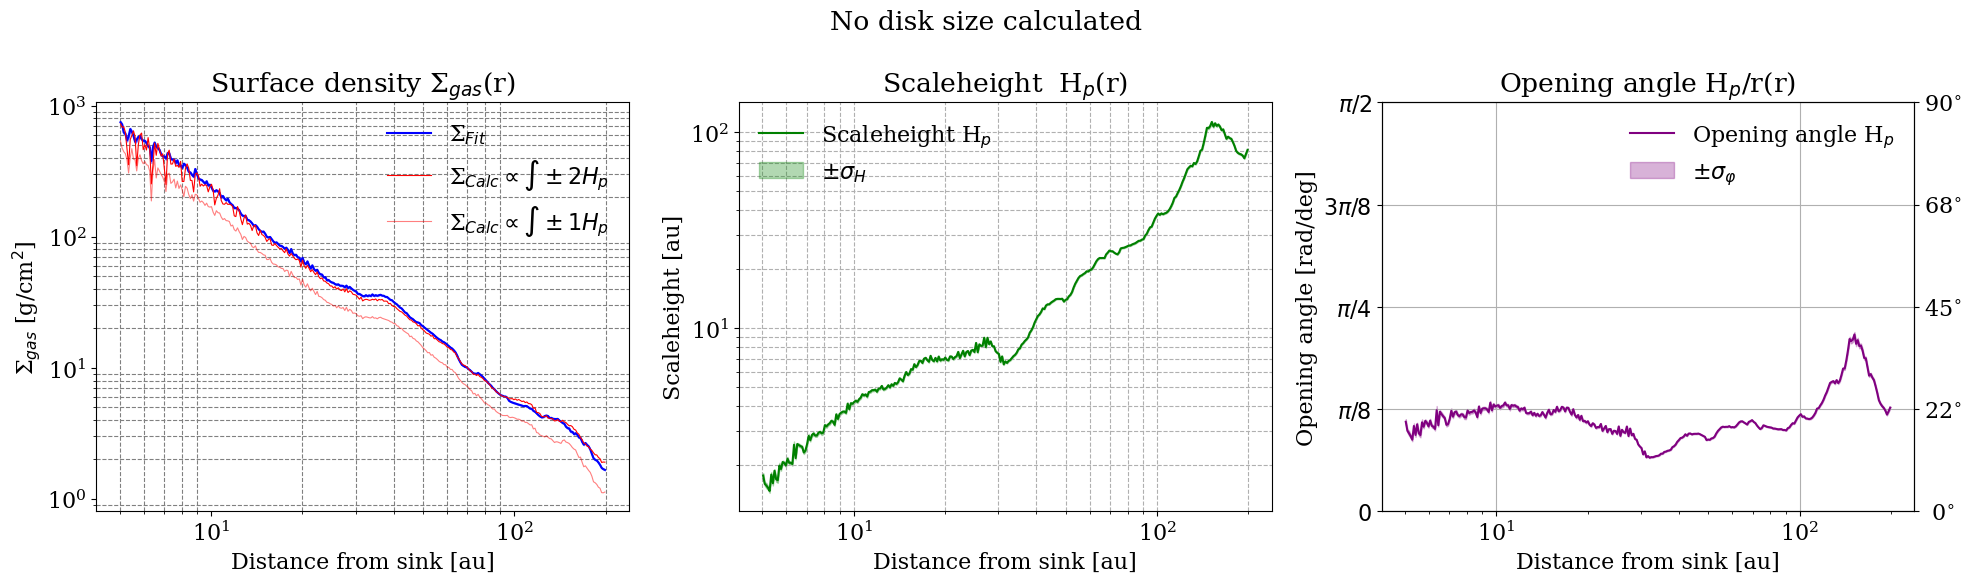

In [4]:
data.to_1D(r_in= 5, r_out = 200, Nr = 300)

# Caclculate Ω

In [5]:
data.get_1D_param(Ω = True)

Extracting azimuthal, angular velocities and adiabatic index data from patches into 1D


100%|██████████| 2356/2356 [00:10<00:00, 233.66it/s]

Σ = g/cm2
φ = rad
H = au
vφ = cm/s
Ω = 1/s
cs = cm/s
Q = dimensionless
B = Gauss
T = K



/lustre/hpc/astro/kxm508/codes/dispatch2/experiments/ISM/python/to_1D/../my_funcs/pipeline_1D.py:187: RuntimeWarning: invalid value encountered in sqrt
  σ_γ = np.sqrt(γ2 - γ**2)


## From pipeline

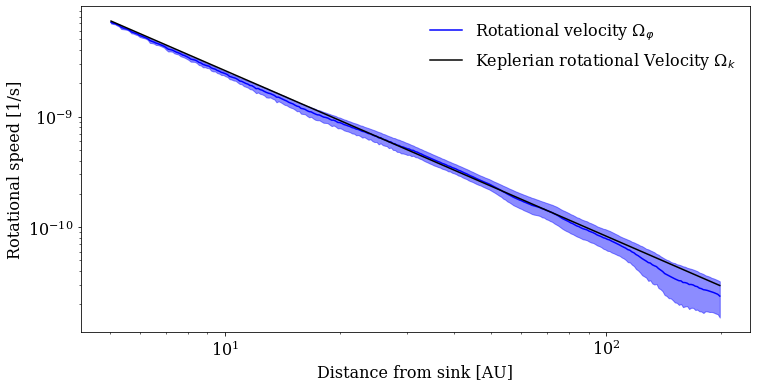

In [6]:
fig, axs = plt.subplots(figsize = (12,6))

axs.loglog(data.r_1D * data.au_length, data.Ω_1D[:,0] , label = 'Rotational velocity Ω$_φ$', c = 'blue')
axs.fill_between(data.r_1D * data.au_length, data.Ω_1D[:,0] + data.Ω_1D[:,1], data.Ω_1D[:,0] - data.Ω_1D[:,1], color = 'blue', alpha = 0.45)
axs.loglog(data.r_1D * data.au_length, data.kepΩr_1D, label = 'Keplerian rotational Velocity Ω$_k$', color = 'black')

axs.set(xlabel = 'Distance from sink [AU]', ylabel = 'Rotational speed [1/s]')
plt.legend(frameon = False, loc = 'upper right')

# Calculate temperature T

### $$ T = \frac{c_s^2\mu m_p}{\gamma k_B}$$ 
### $$\sigma_T = \frac{μ m_p}{k_B}\sqrt{\left(\frac{2c_s}{\gamma}\right)^2\sigma_{c_s}^2 + \left(\frac{c_s^2}{\gamma^2}\right)^2\sigma_\gamma^2}$$

# Calculate the sound speed $C_s$
### $$C_s(r)=H(r)Ω(r)$$
### $$σ_{c_s}^2=σ_Η^2 Ω^2 + σ_Ω^2H^2$$

### $$C_s(r) = \sqrt{\frac{\gamma k_B T}{\mu m_P}}$$
### $$\sigma_{c_s}^2 = \frac{k_B}{2\mu m_P} \left(\frac{\gamma}{T}\sigma_T^2 + \frac{T}{\gamma}\sigma_\gamma^2 \right)$$

In [7]:
cs_settleddisk = np.zeros_like(data.H_1D)
cs_data = np.zeros_like(data.H_1D)
data.calc_cs1D(method = 'settled_disk')
cs_settleddisk = data.cs_1D.copy()
data.get_1D_param(cs=True)

Calculating sound speed assuming a thin settled disk c_s = ΩΗ
Calculating isothermal sound speed c_s = (γP/ρ)^0.5


100%|██████████| 2356/2356 [00:05<00:00, 455.66it/s]

Σ = g/cm2
φ = rad
H = au
vφ = cm/s
Ω = 1/s
cs = cm/s
Q = dimensionless
B = Gauss
T = K


## The settled disk approximation takes the magnetic pressure into account so the sound speed is almost made up by γ P_tot / ρ

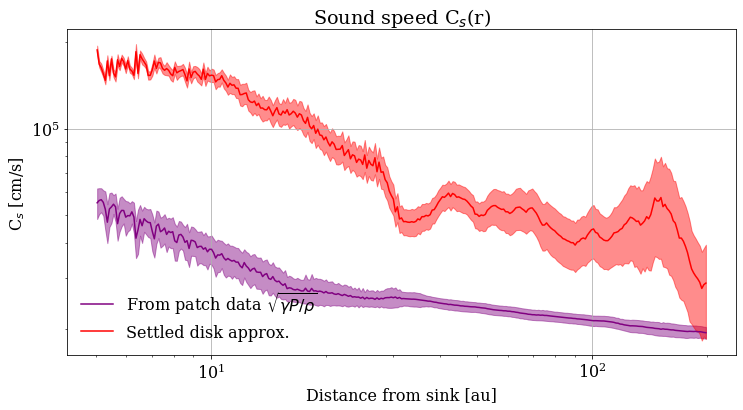

In [8]:
fig, axs = plt.subplots(figsize = (12,6))
axs.grid('--')
axs.loglog(data.r_1D * data.au_length, data.cs_1D[:,0] , color = 'purple', label = 'From patch data $\sqrt{γP/ρ}$')
axs.fill_between(data.r_1D * data.au_length, data.cs_1D[:,0] + data.cs_1D[:,1], data.cs_1D[:,0] - data.cs_1D[:,1], color = 'purple', alpha = 0.45)

axs.loglog(data.r_1D * data.au_length, cs_settleddisk[:,0] , color = 'red', label = 'Settled disk approx.')
axs.fill_between(data.r_1D * data.au_length, cs_settleddisk[:,0] + cs_settleddisk[:,1], cs_settleddisk[:,0] - cs_settleddisk[:,1], color = 'red', alpha = 0.45)

axs.set(title = 'Sound speed C$_s$(r)', ylabel = 'C$_s$ [cm/s]', xlabel = 'Distance from sink [au]')
plt.legend(frameon = False, loc = 'lower left')



In [9]:
data.get_1D_param(T=True)

Calculating temperature from sound speed
Σ = g/cm2
φ = rad
H = au
vφ = cm/s
Ω = 1/s
cs = cm/s
Q = dimensionless
B = Gauss
T = K


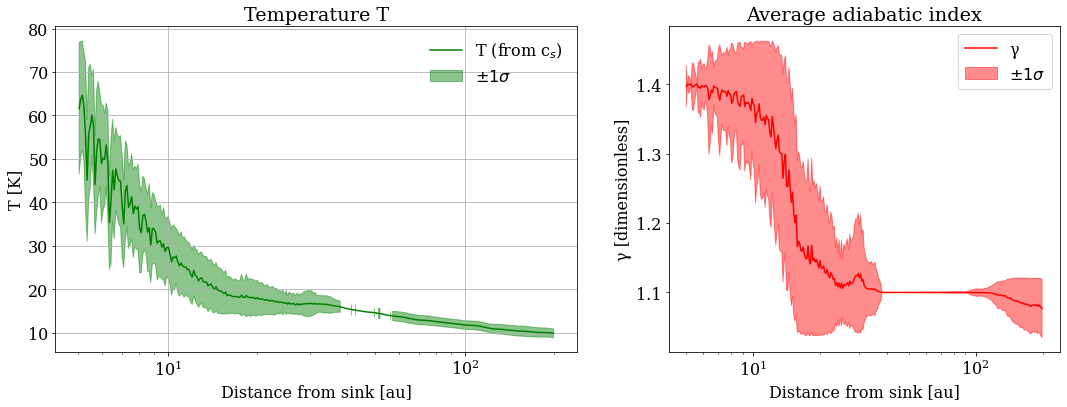

In [10]:
fig, ax = plt.subplots(1,2, figsize = (18,6), gridspec_kw={'width_ratios': [2, 1.5]})
axs = ax[0]
axs.grid('--')

axs.semilogx(data.r_1D * data.au_length, data.T_1D[:,0] , color = 'green', label = 'T (from c$_s$)')
axs.fill_between(data.r_1D * data.au_length, data.T_1D[:,0] + data.T_1D[:,1], data.T_1D[:,0] - data.T_1D[:,1], color = 'green', alpha = 0.45, label = '$\pm 1σ$')

axs.set(title = 'Temperature T', ylabel = 'T [K]', xlabel = 'Distance from sink [au]')
axs.legend(frameon = False)

axs = ax[1]
axs.set(title = 'Average adiabatic index', ylabel = 'γ [dimensionless]', xlabel = 'Distance from sink [au]')

axs.semilogx(data.r_1D * data.au_length, data.γ_1D[:,0] , color = 'red', label = 'γ')
axs.fill_between(data.r_1D * data.au_length, data.γ_1D[:,0] + data.γ_1D[:,1], data.γ_1D[:,0] - data.γ_1D[:,1], color = 'red', alpha = 0.45, label = '$\pm 1σ$')
plt.legend()

# Calculate Toomre Q parameter without magnetic fields
### $$ Q = \frac{c_s\Omega}{\pi G\Sigma} \geq 1\;\Rightarrow\; Stable$$
### $$σ_Q^2 = \frac{1}{(\pi G)^2}\left[σ_{c_s}^2\left(\frac{\Omega}{\Sigma}\right)^2 + σ_\Omega^2\left(\frac{c_s}{\Sigma}\right)^2 + σ^2_\Sigma\left(-\frac{c_s\Omega}{\Sigma}\right)^2\right]$$

Caclulating Toomre Q parameter without magnetic fields
Σ = g/cm2
φ = rad
H = au
vφ = cm/s
Ω = 1/s
cs = cm/s
Q = dimensionless
B = Gauss
T = K


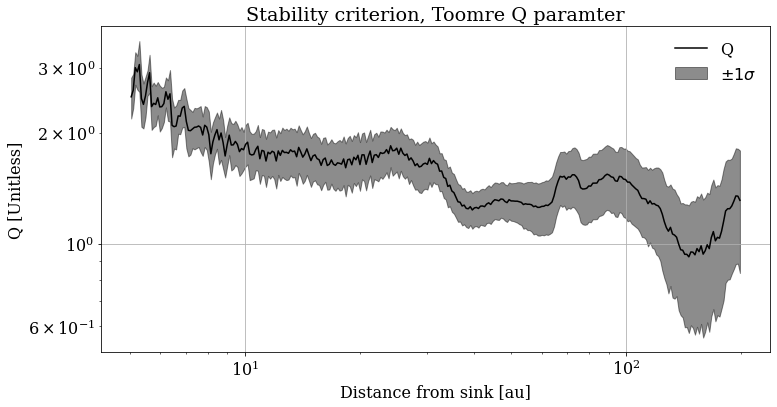

In [11]:
data.get_1D_param(Q = True)
fig, axs = plt.subplots(figsize = (12,6))
axs.grid('--')
axs.loglog(data.r_1D * data.au_length, data.Q_1D[:,0] , color = 'black', label = 'Q')

axs.fill_between(data.r_1D * data.au_length, data.Q_1D[:,0] + data.Q_1D[:,1], data.Q_1D[:,0] - data.Q_1D[:,1], color = 'black', alpha = 0.45, label = '$\pm 1σ$')
axs.set(title = 'Stability criterion, Toomre Q paramter', ylabel = 'Q [Unitless]', xlabel = 'Distance from sink [au]')
axs.legend(frameon = False)

# Calculate Toomre Q parameter without magnetic fields
### $$ Q = \frac{\sqrt{c_s^2 +v_A^2}\Omega}{\pi G\Sigma} < 1.2 - 1.4 \;\Rightarrow\; Stable$$

# But first magnetic fields

In [12]:
data.get_1D_param(B = True)

Extracting magnetic field data from patches into 1D


100%|██████████| 2356/2356 [00:09<00:00, 261.28it/s]

Σ = g/cm2
φ = rad
H = au
vφ = cm/s
Ω = 1/s
cs = cm/s
Q = dimensionless
B = Gauss
T = K


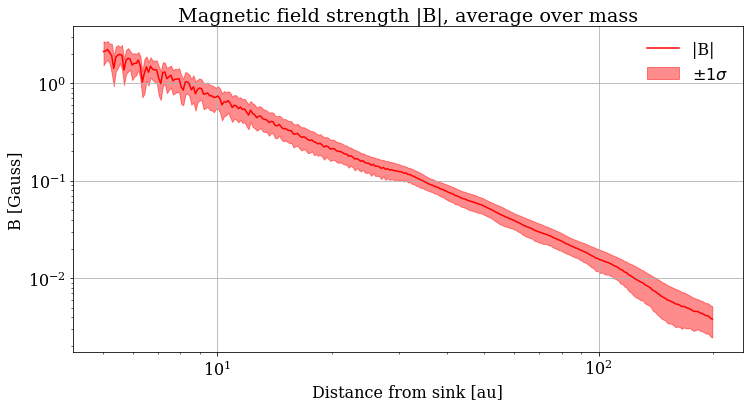

In [13]:
fig, axs = plt.subplots(figsize = (12,6))
axs.grid('--')
axs.loglog(data.r_1D * data.au_length, data.B_1D[:,0] , color = 'red', label = '|B|')

axs.fill_between(data.r_1D * data.au_length, data.B_1D[:,0] + data.B_1D[:,1], data.B_1D[:,0] - data.B_1D[:,1], color = 'red', alpha = 0.45, label = '$\pm 1σ$')
axs.set(title = 'Magnetic field strength |B|, average over mass', ylabel = 'B [Gauss]', xlabel = 'Distance from sink [au]')
axs.legend(frameon = False)

In [14]:
(u.G /np.sqrt( (u.g/u.cm**3) * mu0)).decompose()

<Quantity 0.00282095 m / s>

In [15]:
data.L

array([-0.99835635, -0.0144386 ,  0.05546291])